In [1]:
import os
import sys
import inspect

# Insert modules directory, TODO create setup.py file
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
reports_dir = os.path.dirname(currentdir)
project_home_dir = os.path.dirname(reports_dir)
sys.path.insert(0, f"{project_home_dir}/qcnn")

In [2]:
import numpy as np
import pandas as pd
from pprint import pprint
from reporting_functions import (
    get_file_content,
    get_result_table,
    get_result_table_target_pairs,
)
from joblib import dump, load
from collections import namedtuple

In [3]:
experiments_path = f"{project_home_dir}/experiments"
experiment_filename = "experiment.json"
target_levels = [
    "classical",
    "country",
    "rock",
    "pop",
    "hiphop",
    "jazz",
    "blues",
    "disco",
    "metal",
    "reggae",
]

In [4]:
experiment_id = 119
experiment_config = get_file_content(
    f"{experiments_path}/{experiment_id}/{experiment_filename}"
)

In [5]:
pprint(experiment_config)

{'ID': 119,
 'data': {'path': '/home/matt/dev/projects/quantum-cnn/data/archive/Data/features_30_sec.csv',
          'sampling': {'random_state': 42, 'test_size': 0.3},
          'target_column': 'label',
          'target_pairs': [['classical', 'pop'], ['rock', 'reggae']],
          'type': '2d'},
 'extra_info': 'Building the QCNN one layer at a time but trying to see when '
               'it starts to perform',
 'model': {'classical': {'cnn': {'ignore': True, 'param_grid': {}},
                         'logistic_regression': {'ignore': True,
                                                 'param_grid': {'C': [0.001,
                                                                      0.01,
                                                                      0.1,
                                                                      1.0,
                                                                      10.0,
                                                                      

In [6]:
path = f"{experiment_config.get('path')}/{experiment_config.get('ID')}"

In [7]:
y_test = pd.read_csv(f"{path}/y_test.csv", index_col=0)

In [8]:
model_names = [
    filename.split("-model_configuration.joblib")[0]
    for filename in os.listdir(path)
    if "-model_configuration.joblib" in filename
]

In [9]:
# Gather results
Results = namedtuple(
    "Results", ["model_name", "y_test_hat", "clf", "model_configuration", "samples_tfd"]
)
result_list = []
for model_name in model_names:
    y_test_hat = pd.read_csv(f"{path}/{model_name}-yhat.csv", index_col=0)
    clf = load(f"{path}/{model_name}-clf_results.joblib")
    model_configuration = load(f"{path}/{model_name}-model_configuration.joblib")
    samples_tfd = load(f"{path}/{model_name}-samples_tfd.joblib")
    result_list = result_list + [
        Results(
            model_name,
            y_test_hat=y_test_hat,
            clf=clf,
            model_configuration=model_configuration,
            samples_tfd=samples_tfd,
        )
    ]
print(len(result_list))

28


In [10]:
# Table
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

result_data = pd.DataFrame(
    {
        "model_name": [],
        "model_type": [],
        "algorithm": [],
        "classification_type": [],
        "embedding_type": [],
        "scaler_method": [],
        "scaler_param_str": [],
        "selection_method": [],
        "selection_param_str": [],
        "target_pair": [],
        "additional_structure": [],
        "target_pair_str": [],
        "mean_test_score": [],
        "std_test_score": [],
        "params": [],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "loss_train_history": [],
    }
)
for result in result_list:
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    precision, recall, fscore, support = precision_recall_fscore_support(
        samples_tfd.y_test, y_test_hat, average="binary"  # TODO multiclass
    )
    accuracy = accuracy_score(samples_tfd.y_test, y_test_hat)
    tmp_result = model_configuration._asdict()
    tmp_result["model_name"] = model_name

    tmp_result["target_pair_str"] = "_".join(model_configuration.target_pair)
    tmp_result["mean_test_score"] = clf.cv_results_["mean_test_score"][clf.best_index_]
    tmp_result["std_test_score"] = clf.cv_results_["std_test_score"][clf.best_index_]
    tmp_result["params"] = clf.cv_results_["params"][clf.best_index_]

    tmp_result["accuracy"] = accuracy
    tmp_result["precision"] = precision
    tmp_result["recall"] = recall
    tmp_result["f1"] = fscore
    tmp_result["loss_train_history"] = None  # set for quantum
    result_data = result_data.append(tmp_result, ignore_index=True)

In [11]:
result_data.fillna("None", inplace=True)
result_data.head()

,model_name,model_type,algorithm,classification_type,embedding_type,scaler_method,scaler_param_str,selection_method,selection_param_str,target_pair,additional_structure,target_pair_str,mean_test_score,std_test_score,params,accuracy,precision,recall,f1,loss_train_history
0,quantum-qcnn-binary-Angle-minmax-max_features=...,quantum,qcnn,binary,Angle,minmax,max_features=8_n_estimators=50,tree,"feature_range=[0, 1.5707963267948966]","[classical, pop]",custom_1,classical_pop,-11.758060,2.056888,{'n_iter': 50},0.930233,1.000000,0.869565,0.930233,None
1,quantum-qcnn-binary-Angle-minmax-max_features=...,quantum,qcnn,binary,Angle,minmax,max_features=8_n_estimators=50,tree,"feature_range=[0, 1.5707963267948966]","[rock, reggae]",custom_0,rock_reggae,-15.943111,0.920949,{'n_iter': 50},0.593750,0.615385,0.275862,0.380952,None
2,quantum-qcnn-binary-Angle-minmax-max_features=...,quantum,qcnn,binary,Angle,minmax,max_features=8_n_estimators=50,tree,"feature_range=[0, 1.5707963267948966]","[classical, pop]",custom_4,classical_pop,-9.182690,0.899172,{'n_iter': 50},0.953488,1.000000,0.913043,0.954545,None
3,quantum-qcnn-binary-Angle-minmax-n_components=...,quantum,qcnn,binary,Angle,minmax,n_components=8,pca,"feature_range=[0, 1.5707963267948966]","[classical, pop]",custom_2,classical_pop,-22.998597,1.031227,{'n_iter': 50},0.418605,0.450000,0.391304,0.418605,None
4,quantum-qcnn-binary-Angle-minmax-max_features=...,quantum,qcnn,binary,Angle,minmax,max_features=8_n_estimators=50,tree,"feature_range=[0, 1.5707963267948966]","[rock, reggae]",custom_5,rock_reggae,-14.040907,0.957598,{'n_iter': 50},0.765625,0.694444,0.862069,0.769231,None


In [14]:
get_result_table(
    result_data,
    ["algorithm", "additional_structure","selection_method", "target_pair_str"],
    "accuracy",
)

target_pair_str,classical_pop,rock_reggae,algorithm Average
"(qcnn, custom_0, pca)",0.488372,0.500000,0.494186
"(qcnn, custom_0, tree)",0.581395,0.593750,0.587573
"(qcnn, custom_1, pca)",0.534884,0.453125,0.494004
"(qcnn, custom_1, tree)",0.930233,0.703125,0.816679
"(qcnn, custom_2, pca)",0.418605,0.625000,0.521802
"(qcnn, custom_2, tree)",0.883721,0.531250,0.707485
"(qcnn, custom_3, pca)",0.930233,0.671875,0.801054
"(qcnn, custom_3, tree)",0.790698,0.562500,0.676599
"(qcnn, custom_4, pca)",0.953488,0.718750,0.836119
"(qcnn, custom_4, tree)",0.953488,0.796875,0.875182


In [15]:
get_result_table(
    result_data,
    ["algorithm", "additional_structure", "target_pair_str"],
    "mean_test_score",
)

target_pair_str,classical_pop,rock_reggae,algorithm Average
"(qcnn, custom_0)",-19.518715,-17.599746,-18.559231
"(qcnn, custom_1)",-17.929414,-17.684228,-17.806821
"(qcnn, custom_2)",-17.826803,-17.173215,-17.500009
"(qcnn, custom_3)",-10.518184,-14.602685,-12.560435
"(qcnn, custom_4)",-9.806339,-12.926579,-11.366459
"(qcnn, custom_5)",-6.985697,-12.481839,-9.733768
"(qcnn, custom_6)",-6.368064,-11.813891,-9.090978
additional_structure Average,-12.707603,-14.897455,-13.802529


In [16]:
get_result_table(
    result_data,
    ["algorithm", "additional_structure", "target_pair_str"],
    "std_test_score",
)

target_pair_str,classical_pop,rock_reggae,algorithm Average
"(qcnn, custom_0)",1.410062,1.216609,1.313335
"(qcnn, custom_1)",1.483779,1.279543,1.381661
"(qcnn, custom_2)",1.521393,0.976547,1.248970
"(qcnn, custom_3)",4.016796,2.285791,3.151293
"(qcnn, custom_4)",3.819057,1.149503,2.484280
"(qcnn, custom_5)",1.673749,1.098746,1.386248
"(qcnn, custom_6)",1.639838,1.105902,1.372870
additional_structure Average,2.223525,1.301806,1.762665


In [17]:
#target_pair = ["classical", "disco"]
# target_pair = ["pop", "disco"]
# target_pair = ["rock", "blues"]
target_pair = ["rock", "reggae"]
filtered_results = [
    result
    for result in result_list
    if result.model_configuration.target_pair == target_pair
]
# filtered_results = [
#     result for result in result_list if genre in result.model_configuration.target_pair
# ]

/home/matt/dev/projects/quantum-cnn/python_env/qcnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matt/dev/projects/quantum-cnn/python_env/qcnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matt/dev/projects/quantum-cnn/python_env/qcnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

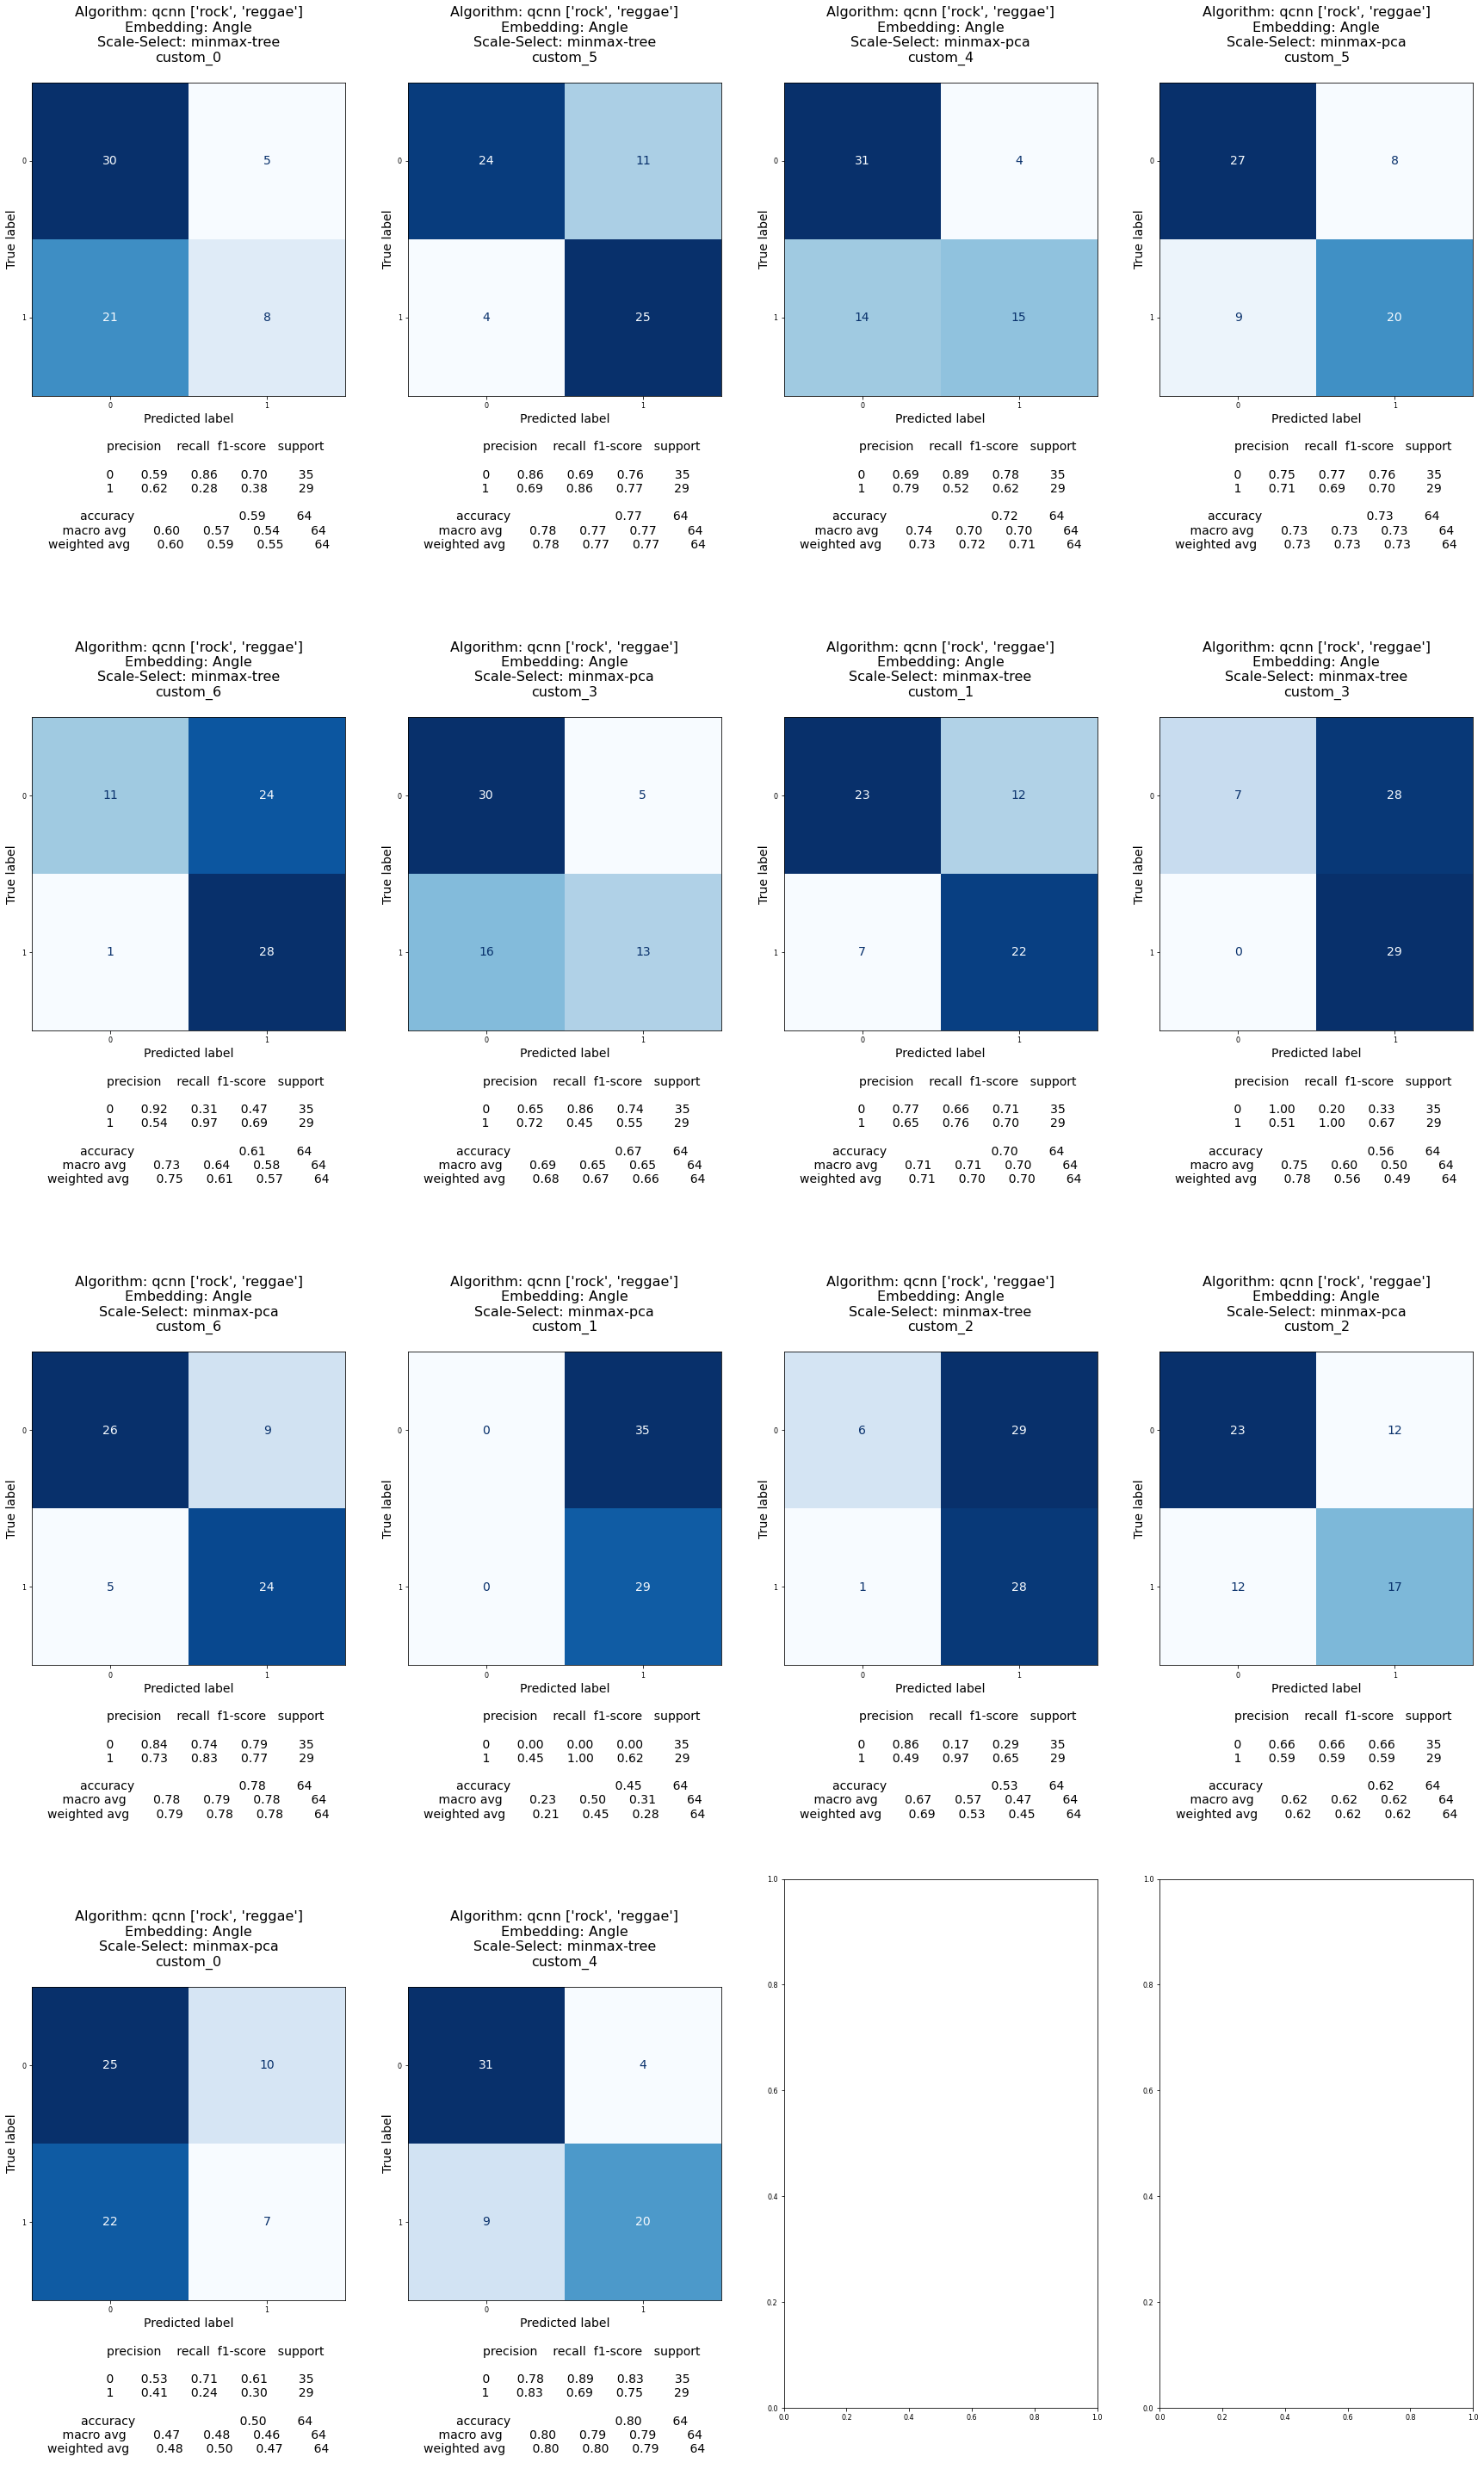

<Figure size 432x288 with 0 Axes>

In [18]:
%matplotlib inline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt

# Customize matplotlib
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

row_width = 30
row_height = 13
columns_in_row = 4
n_plots = len(filtered_results)
n_rows = int(np.ceil(n_plots / columns_in_row))
fig, axes = plt.subplots(n_rows, columns_in_row, figsize=(row_width, n_rows * row_height))
for result, i in zip(filtered_results, range(n_plots)):
    col = i % columns_in_row
    row = int(np.floor(i / columns_in_row))
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    display_report = classification_report(samples_tfd.y_test, y_test_hat)
    title_text = (
        f"Algorithm: {model_configuration.algorithm} {model_configuration.target_pair}\n"
        f"Embedding: {model_configuration.embedding_type}\n"
        f"Scale-Select: {model_configuration.scaler_method}-{model_configuration.selection_method}\n"
        f"{model_configuration.additional_structure}\n"
    )
    axes[row, col].grid(False)
    ConfusionMatrixDisplay.from_predictions(
        samples_tfd.y_test, y_test_hat, ax=axes[row, col], cmap=plt.cm.Blues
    )

    axes[row, col].set_title(title_text)
    axes[row, col].set_xlabel(f"Predicted label\n\n{display_report}")
    im = axes[row, col].images
    cb = im[-1].colorbar
    cb.remove()


plt.close()
plt.tight_layout()
fig